# Matrix Factorisation - Intuition

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd

In [3]:
ratings = pd.read_csv("data/ratings.csv")
items = pd.read_csv("data/items.csv")
users = pd.read_csv("data/users.csv")

In [4]:
ratings.head()

,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


## Small Data

| movie_id | title                 |
| -------: | :-------------------- |
|      1   | Toy Story (1995)      |
|     71   | Lion King, The (1994) |
|     95   | Aladdin (1992)        |
|     50   | Star Wars (1972)      |
|    176   | Aliens (1986)         |
|     82   | Jurassic Park (1993)  |


In [23]:
from recoflow.datasets import SampleData

In [24]:
sample_users, sample_items, sample_ratings = SampleData(users, items, ratings)

In [25]:
from recoflow.preprocessing import EncodeUserItem

In [26]:
interaction, n_users, n_items, user_encoder, item_encoder = EncodeUserItem(sample_ratings,
                                                         "user_id", "movie_id", "rating", "unix_timestamp")

Number of users:  10
Number of items:  6


In [27]:
interaction.head()

,user_id,movie_id,RATING,TIMESTAMP,USER,ITEM
1052,2,50,5,888552084,1,1
1090,8,50,5,879362124,4,1
3672,6,95,2,883602133,2,4
4280,1,82,5,878542589,0,3
4596,12,82,4,879959610,6,3


In [57]:
max_rating = interaction.RATING.max()
min_rating = interaction.RATING.min()
min_rating, max_rating

(1, 5)

In [28]:
from recoflow.vis import InteractionVis, TrainTestVis

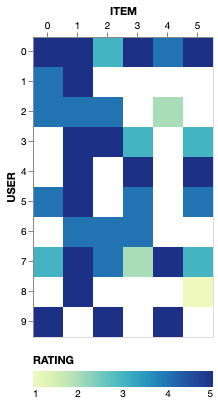

In [29]:
InteractionVis(interaction)

In [30]:
from recoflow.preprocessing import RandomSplit, StratifiedSplit, ChronoSplit

In [99]:
train, test = RandomSplit(interaction, [0.6, 0.4])

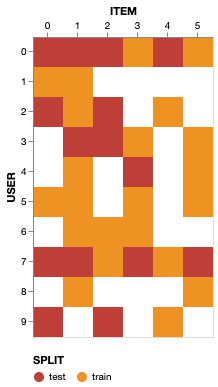

In [100]:
TrainTestVis(train, test)

## Build Model

In [101]:
from recoflow.models import ExplicitMatrixFactorisationBias

In [155]:
n_factors = 2
model = ExplicitMatrixFactorisationBias(n_users, n_items, n_factors, max_rating, min_rating)

In [156]:
model.summary()

Model: "ExplicitMatrixFactorisationBias"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
ItemEmbedding (Embedding)       (None, 1, 2)         12          Item[0][0]                       
__________________________________________________________________________________________________
UserEmbedding (Embedding)       (None, 1, 2)         20          User[0][0]                       
____________________________________________________________________

In [157]:
%%time
output = model.fit([train.USER, train.ITEM], train.RATING, shuffle=True, batch_size=1, epochs=100, verbose=0, 
                   validation_data=([test.USER, test.ITEM], test.RATING))

CPU times: user 8.51 s, sys: 1.25 s, total: 9.75 s
Wall time: 7.33 s


In [158]:
from recoflow.vis import MetricsVis

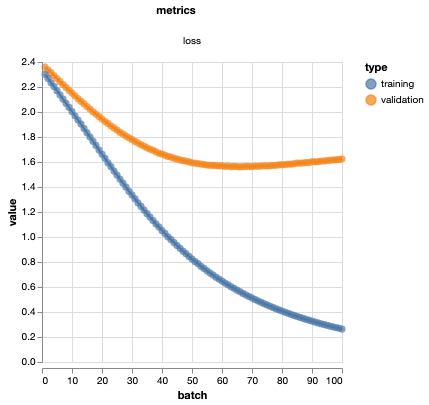

In [159]:
MetricsVis(output.history)

In [160]:
from recoflow.recommend import UserEmbedding, ItemEmbedding

In [161]:
item_embedding = UserEmbedding(model, "ItemEmbedding")
user_embedding = ItemEmbedding(model, "UserEmbedding")

In [162]:
item_embedding

array([[ 0.4266383 ,  0.43679917],
       [ 0.7709527 ,  1.0180782 ],
       [ 0.49435946, -0.35138014],
       [ 0.72814727, -0.51169   ],
       [ 0.80276716, -0.93691117],
       [ 0.88108987, -0.6649029 ]], dtype=float32)

In [163]:
user_embedding

array([[ 0.7634384 , -0.7496685 ],
       [ 0.5777171 ,  0.602675  ],
       [-0.24383129,  0.75017303],
       [-0.14105083,  0.05877911],
       [ 0.85818356,  0.08425549],
       [ 0.80780387,  0.36935842],
       [ 0.5184164 , -0.15546027],
       [ 0.5371777 , -0.62514496],
       [-0.1534093 ,  0.8556748 ],
       [ 0.5974195 , -0.5847428 ]], dtype=float32)

In [212]:
from recoflow.vis import EmbeddingVis

ImportError: cannot import name 'EmbeddingVis' from 'recoflow.vis' (/Users/amitkaps/miniconda3/envs/ml/lib/python3.7/site-packages/recoflow/vis.py)

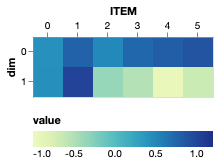

In [209]:
EmbeddingVis(item_embedding, n_factors, "ITEM")

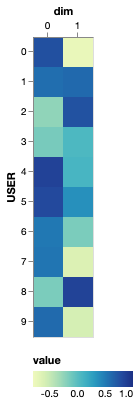

In [210]:
EmbeddingVis(user_embedding, n_factors, "USER")

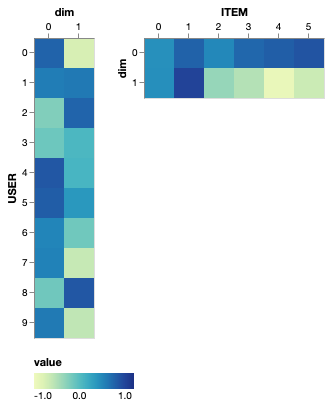

In [211]:
EmbeddingVis(user_embedding, n_factors, "USER") | EmbeddingVis(item_embedding, n_factors, "ITEM") 

In [213]:
from recoflow.recommend import GetPredictions, GetRankingTopK

In [214]:
predictions = GetPredictions(model, interaction)

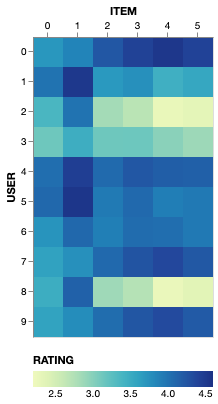

In [216]:
InteractionVis(predictions)

In [319]:
def SimilarityVis(item_embedding, user_embedding):
    
    item_embedding_df_wide = pd.DataFrame(item_embedding)
    user_embedding_df_wide = pd.DataFrame(user_embedding)

    item_embedding_df_wide.reset_index(inplace=True)
    item_embedding_df_wide["idx"] = item_embedding_df_wide["index"].apply(lambda x: "I" + str(x))
    item_embedding_df_wide.columns = ["index", "X0", "X1", "idx" ]

    user_embedding_df_wide.reset_index(inplace=True)
    user_embedding_df_wide["idx"] = user_embedding_df_wide["index"].apply(lambda x: "U" + str(x))
    user_embedding_df_wide.columns = ["index", "X0", "X1", "idx" ]

    embedding_df_wide = pd.concat([item_embedding_df_wide, user_embedding_df_wide])
    
    base = alt.Chart(edf).encode(
        alt.X("X0:Q", axis = alt.Axis(bandPosition = 0.5)),
        alt.Y("X1:Q", axis = alt.Axis(bandPosition = 0.5))
    )

    vis = base.mark_point(size=0) + base.mark_text().encode(text="idx")
    
    return vis

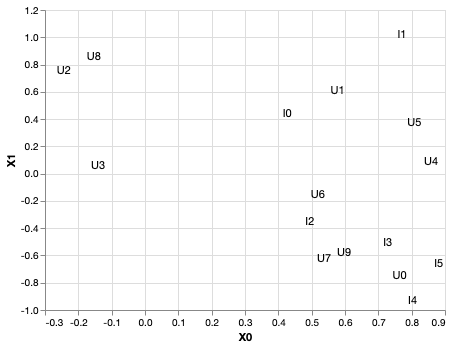

In [320]:
SimilarityVis(item_embedding, user_embedding)

In [299]:
edf.head()

,index,X0,X1,idx
0,0,0.426638,0.436799,I0
1,1,0.770953,1.018078,I1
2,2,0.494359,-0.351380,I2
3,3,0.728147,-0.511690,I3
4,4,0.802767,-0.936911,I4


In [316]:
base = alt.Chart(edf).encode(
    alt.X("X0:Q", axis = alt.Axis(bandPosition = 0.5)),
    alt.Y("X1:Q", axis = alt.Axis(bandPosition = 0.5))
)

vis = base.mark_point(size=1) + base.mark_text().encode(text="idx")